# '매장 데이터 예측' 프로그램에 오신 것을 환영합니다.


기계 학습 기술은 미래의 추세를 예측하는 데 유용할 수 있습니다. 한 달 정도 후에 날씨가 흐릴지, 오늘 주가를 기준으로 내일 주식이 어떻게 움직일지, 또는 고객의 소비 습관과 매장 매출을 기반으로 더 많은 수익을 올릴 수 있는지 예측할 수 있습니다. 여기에서는 Rosemann이라는 유럽 슈퍼마켓 체인의 데이터를 기반으로 어떤 요인이 매출 증가로 이어질 수 있는지 예측해보고자 합니다.
데이터 세트는 https://www.kaggle.com/c/rossmann-store-sales/data 에서 찾을 수 있습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb 
# 온라인 표시를 위해 그림 크기 조정
plt.rcParams['figure.figsize'] = (12.0, 10.0)

## 훈련 데이터 가져오기




In [22]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv(r"./Module37/train.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv(r"./Module37/store.csv")

## 데이터 탐색

시각적 탐색을 사용하여 데이터 세트를 탐색하고 데이터의 특성을 이해합니다. 이제 데이터를 시각화하고 데이터 세트가 어떻게 되는지 살펴보겠습니다.

In [10]:
# 먼저 수동으로 분리할 수 있는 항목을 찾기 위해 데이터를 탐색합니다.
# 이곳에서 매출이 있었던 폐업한 매장이 있는지 분석하려고 합니다.

not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No Closed store with sales: " + str(not_open.size == 0))


No Closed store with sales: True


In [12]:
# 이곳에서는 오픈이지만 매출이 없었던 매장이 있는지 분석해보려고 합니다. 
# 기본 사례가 확인되었으며 데이터가 안전한지 확인할 수 있습니다.
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


In [23]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

In [24]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))
# 판매가 발생한 날짜 범위는 아래에서 볼 수 있습니다.

Start date:  2015-06-01T00:00:00.000000000
End Date:  2015-07-31T00:00:00.000000000


## 데이터 시각화

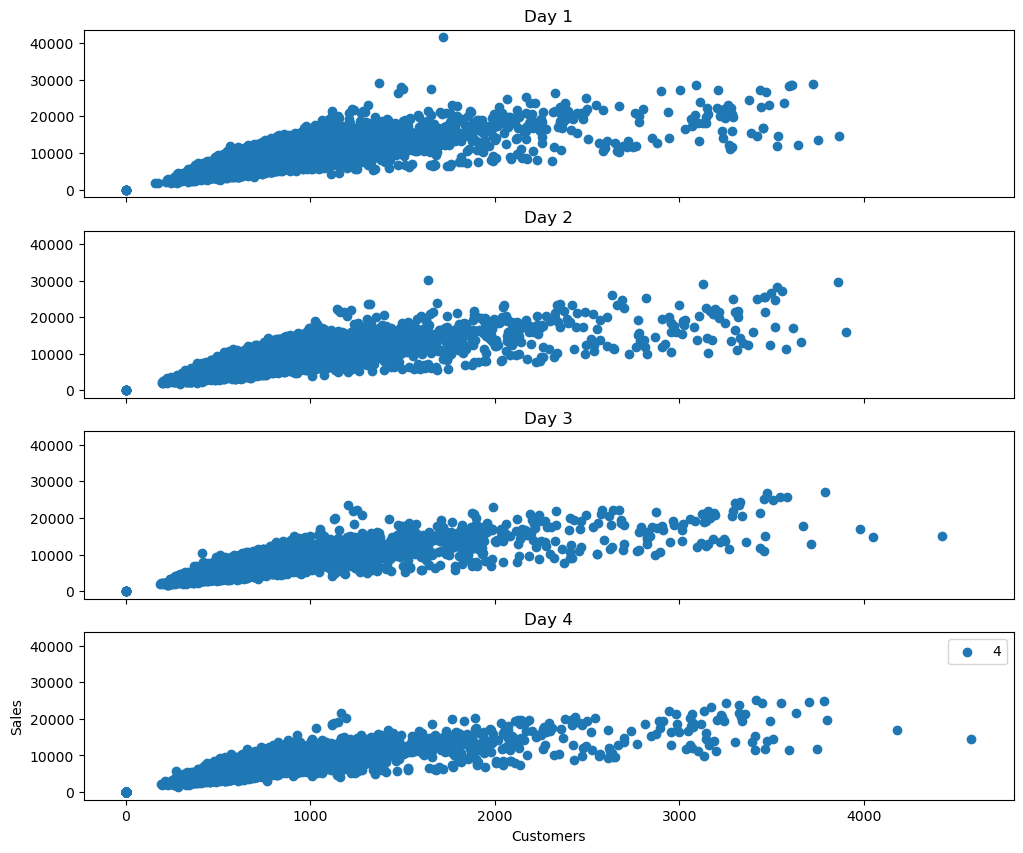

In [14]:
# 일별 매출 추이를 봅시다.
f, ax = plt.subplots(4, sharex=True, sharey=True)
for i in range(1, 5):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

## 다양한 변수가 판매에 미치는 영향 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_9884\2957557406.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))


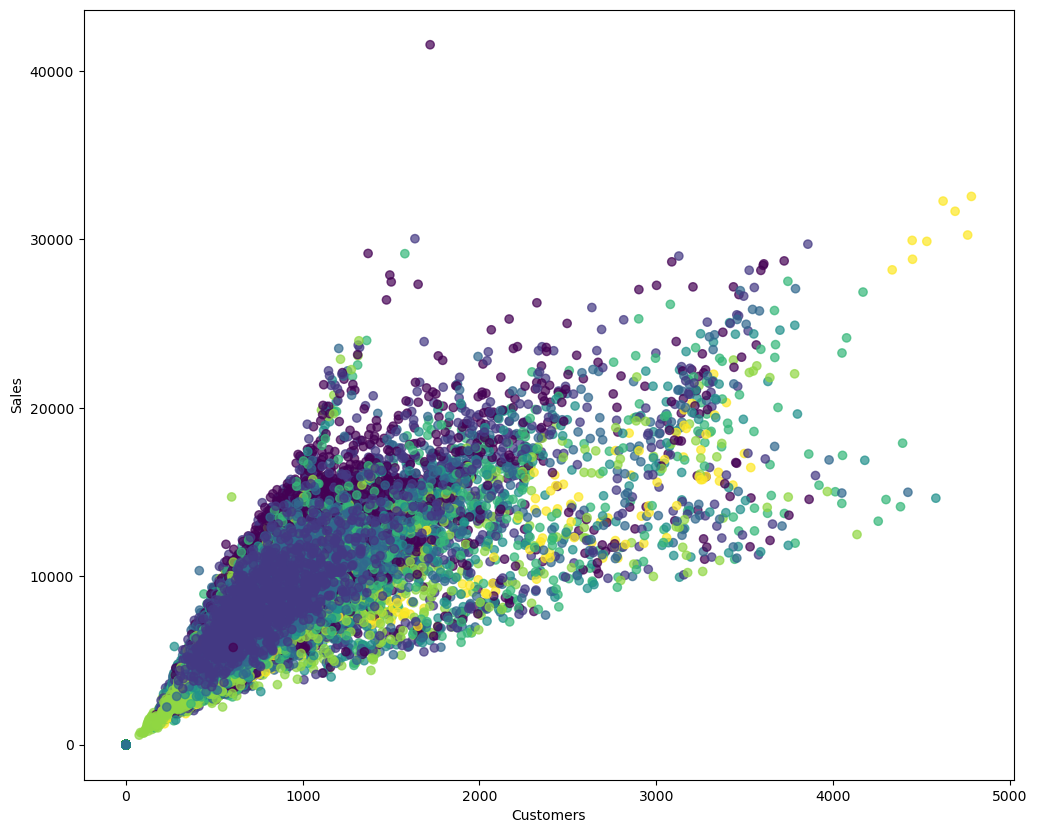

In [15]:
# 고객과 매출의 상관관계를 시각화합니다.
# 그래프에서 볼 수 있듯이 일반적인 상관관계가 있습니다.
# 아래 그래프에서 다양한 요일의 판매 기울기가 있음을 알 수 있습니다.
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

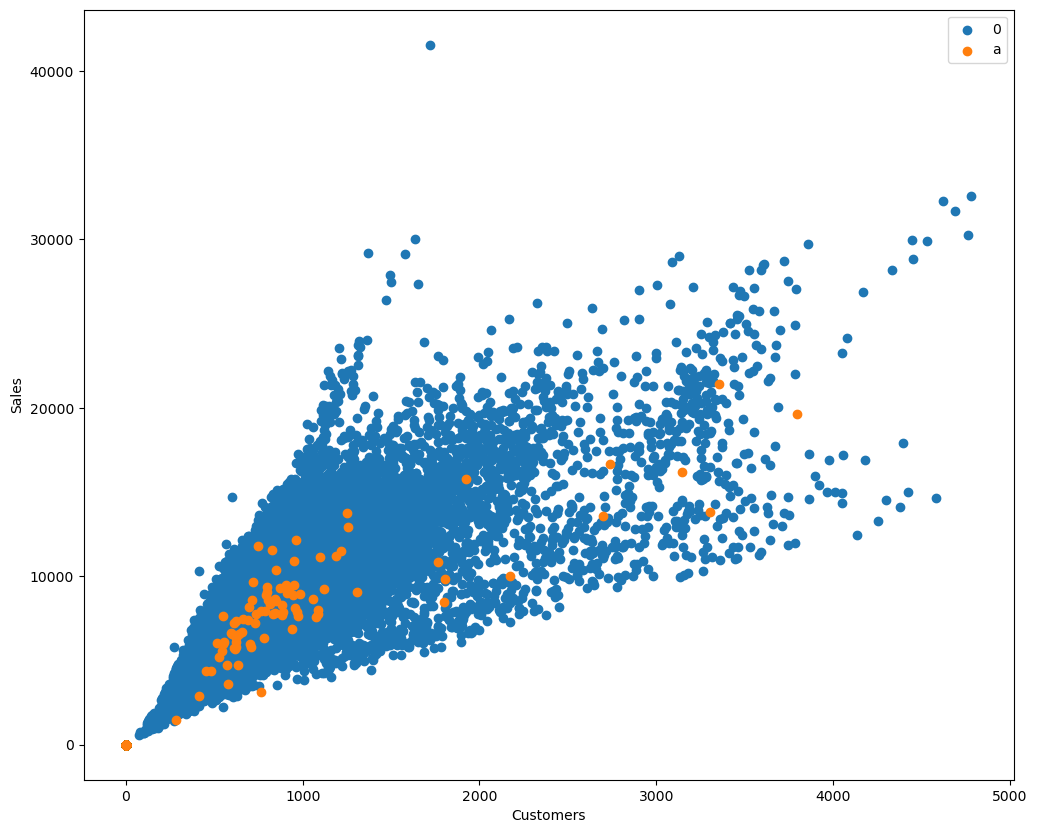

In [16]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()
#크리스마스 연휴가 공휴일보다 더 영향력이 크다는 것을 알 수 있습니다.

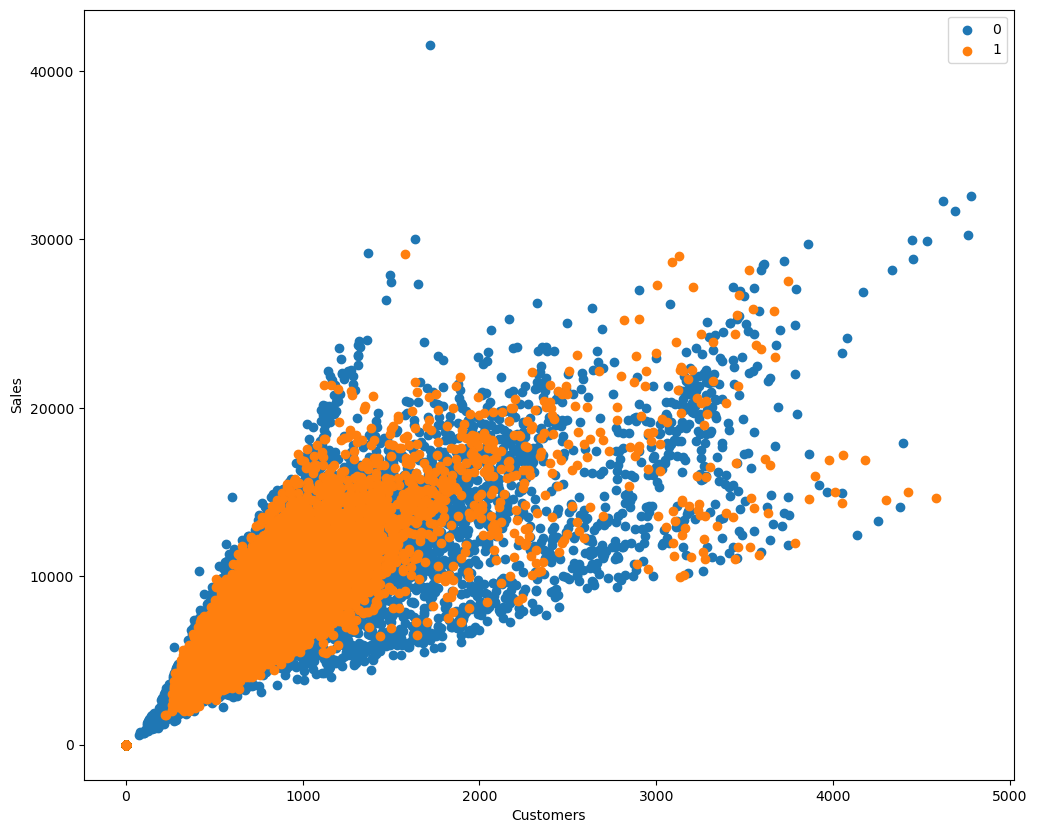

In [17]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()
# 아래 그래프에서 알 수 있습니다. 방학은 큰 영향을 미치지 않습니다.

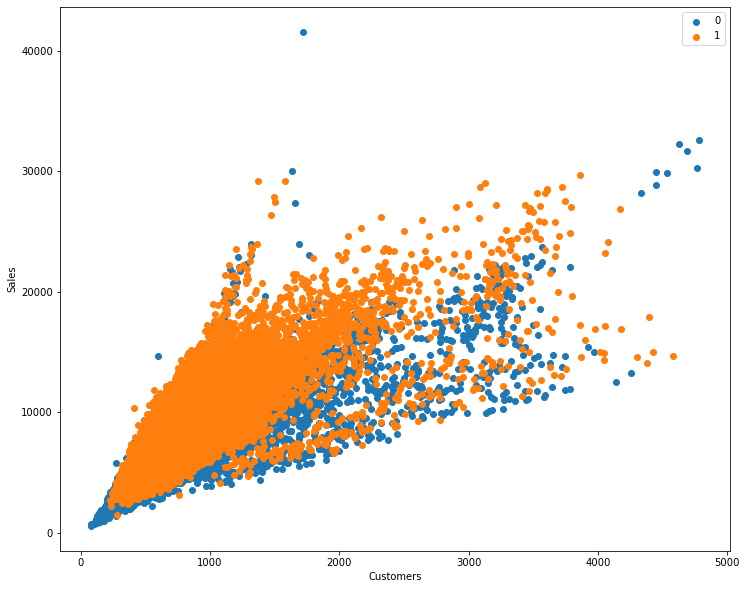

In [18]:
# 다양한 프로모션의 효과 확인하기
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()
# 아래 그래프에서 프로모션은 두 매장 그룹에 대해 약간의 다른 효과를 가질 수 있습니다.
# 자세한 내용은 store.csv를 참조하세요.

## 매장 통계 계산 및 매장 동향 보기

In [25]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
print(avg_store)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

           AvgSales  AvgCustomers  AvgSalesPerCustomer
Store                                                 
1       4447.634615    510.211538             8.670743
2       4998.769231    596.557692             8.459276
3       7095.274510    716.843137             9.785061
4       9843.288462   1271.461538             7.702043
5       4612.211538    522.980769             8.764831
...             ...           ...                  ...
1111    4800.078431    391.921569            12.033602
1112    9087.803922    719.745098            12.457218
1113    6533.230769    669.442308             9.721218
1114   22626.038462   3399.576923             6.643718
1115    7131.784314    467.745098            15.083511

[1115 rows x 3 columns]


,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4447.634615,510.211538,8.670743,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4998.769231,596.557692,8.459276,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7095.274510,716.843137,9.785061,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9843.288462,1271.461538,7.702043,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4612.211538,522.980769,8.764831,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


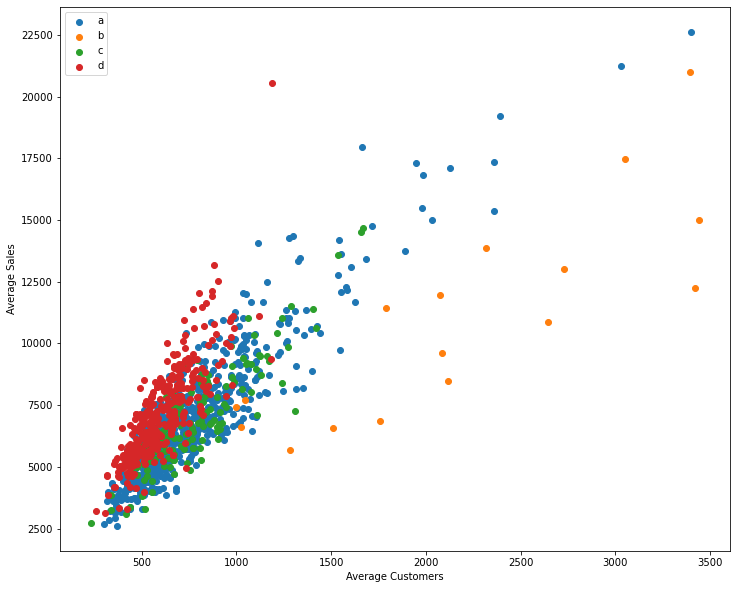

In [20]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()
# 아래 그래프에서 'b'와 같이 특정 매장 유형의 고객이 더 적게 지출한다는 것을 알 수 있습니다.

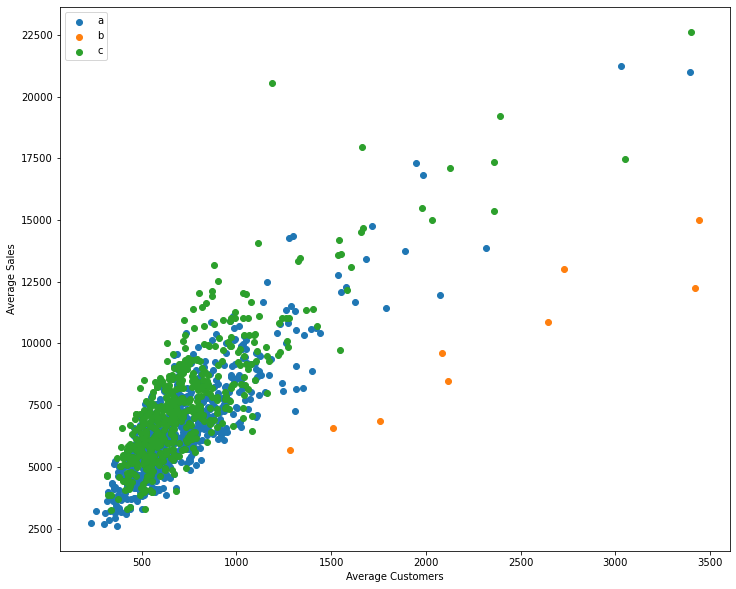

In [21]:
# 여러 변화 확인하기
for i in ['a', 'b', 'c']:
    data = store[store['Assortment'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()
# 아래 그래프에서 'b'와 같이 특정 구색의 고객이 더 적게 지출한다는 것을 알 수 있습니다.

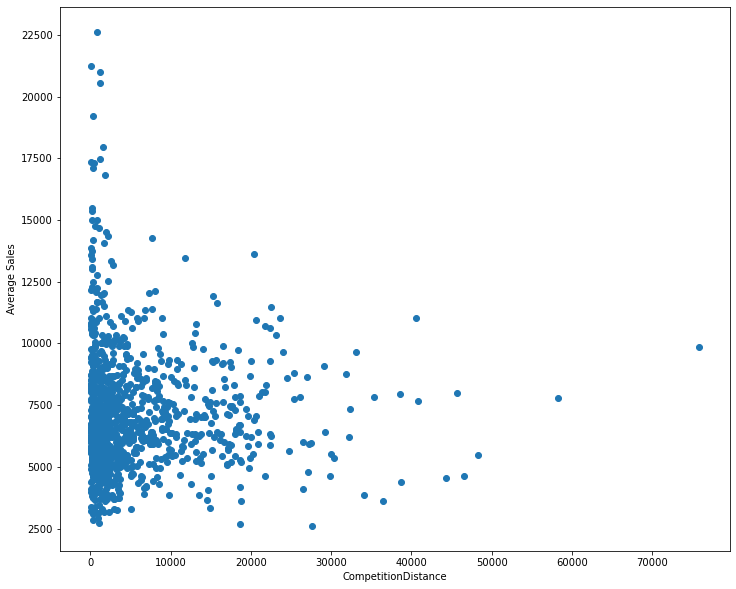

In [22]:
# NaN 값 채우기
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()
# 아래 그래프에서 다음과 같은 추세를 볼 수 있습니다. 경쟁이 치열할수록 더 많은 수익이 발생합니다.

## 모델 구축

In [26]:
# 첫 번째 직감으로는 점포 형태, 휴일 여부 등의 특징에 따라 
# 배율이 뚜렷하게 구분되는 부분이 있기 때문에 의사 결정 트리가 좋은 것 같다.

def build_features(train, store):
    # 문자열 유형을 정수로 변환
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')
    
    # NaN 제거
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    #merged['Week'] = merged.Date.dt.week
    merged['Week'] = merged['Date'].dt.isocalendar().week

    
    # 경쟁이 존재한 개월 수
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    # CompetitionOpenSinceYear가 0이면 그 행의 MonthsCompetitionOpen값도 0으로 설정
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace
    
    # 프로모션이 존재한 주 수
    merged['WeeksPromoOpen'] = \
        52 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Week'] - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] == 
               NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,...,0,0,0,0,2015,7,31,31,82,0
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,31,92,278
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,31,103,225
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457,...,0,0,0,0,2015,7,31,31,70,0
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118,...,0,0,0,0,2015,7,31,31,3,0


In [27]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    #'MedSales',
    #'MedCustomers',
    #'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)


In [29]:
from sklearn.metrics import make_scorer

# kaggle에 따른 오류 계산 함수
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

## 결과

의사 결정 트리 및 랜덤 포레스트 결과 플로팅

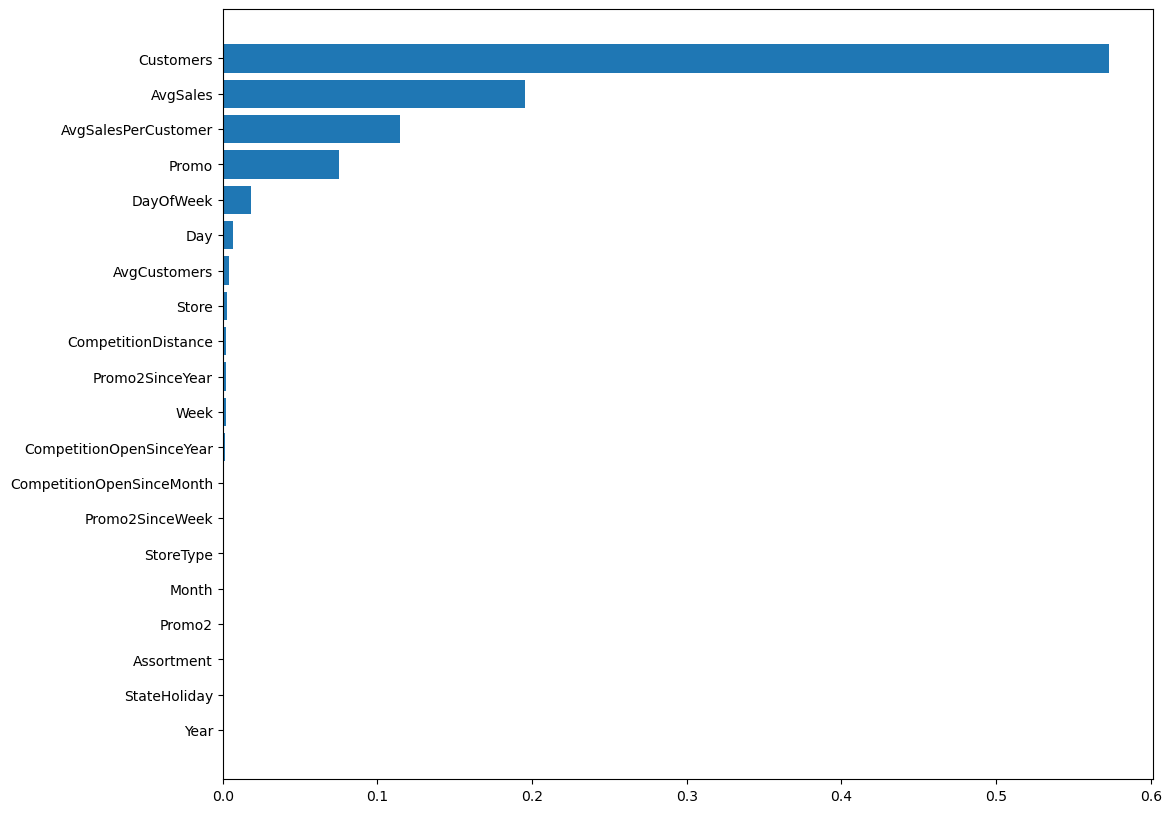

In [30]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)
# 의사결정 트리에 따른 매출에 영향을 미치는 요인별 내림 차순 정렬(중요도 높은 순서)

In [31]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

Mean -0.08597523134866975
Variance 1.2861746849852602e-06
RMSPE 0.08517206838321709


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished


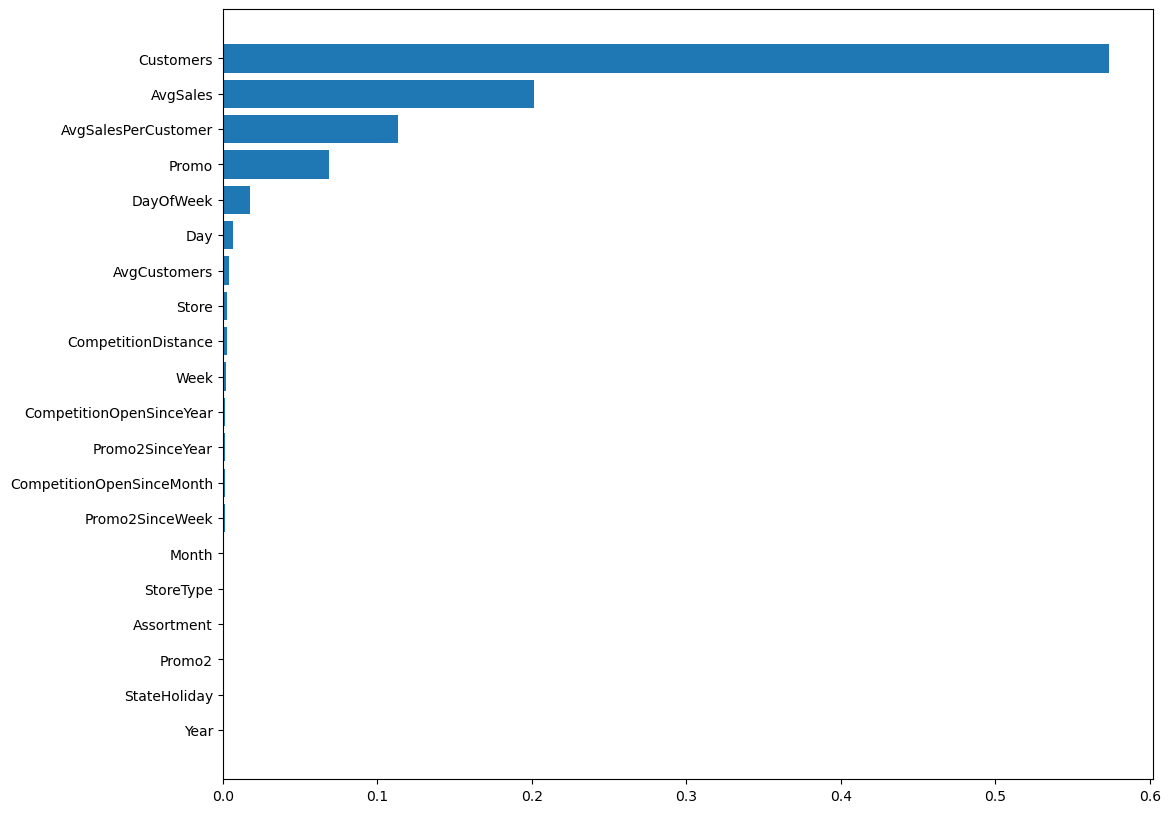

In [32]:
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)
# 랜덤 포레스트에 따른 매출에 영향을 미치는 요인별 내림 차순 정렬(중요도 높은 순서)

In [33]:
y_hat = randomForest.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  25 out of  25 | elapsed:    0.0s finished


Mean -0.08598125873077792
Variance 1.1770015082727953e-06
RMSPE 0.06351838967562093


## 결론
판매 예측은 매장의 매출을 높일 수 있는 기계 학습의 중요한 활용 분야입니다. 이 노트북에서 우리는 Rosemann 매장 판매 데이터 세트를 이용하여 특성을 파악하고 매출을 높이기 위한 가장 중요한 특성이 무엇인지 예측했습니다. 판매 예측은 앞으로의 판매 추세를 파악하고 여러 특성들의 영향을 판단할 수 있습니다. 또한 예상 수요에 맞게 재고량 등의 리소스를 관리할 수 있으며, 향후 예산을 계획하는 데 사용할 수 있습니다.